In [1]:
import numpy as np
import pandas as pd
import talib

from mplfinance.original_flavor import candlestick_ohlc
import seaborn as sns
import matplotlib.pyplot as plt
# import matplotlib.dates as mpdates
%matplotlib inline

In [2]:
pair = 'BTC_USDT'
timeframe = '15m'
exchange = 'binance'


df = pd.read_json(f'data/{exchange}/{pair}-{timeframe}.json')
df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
df = df.set_index(['time'])
df['hl2']  = (df['high']+df['low'])/2
df['hlc3'] = (df['high']+df['low']+df['close'])/3
df['ohlc4'] = (df['open']+df['high']+df['low']+df['close'])/4
df = df[-200:]
df.head()

,open,high,low,close,volume,hl2,hlc3,ohlc4
time,,,,,,,,
1661679000000,20030.21,20038.32,20015.00,20029.56,775.73783,20026.660,20027.626667,20028.2725
1661679900000,20029.56,20039.74,19995.57,20020.00,1141.41594,20017.655,20018.436667,20021.2175
1661680800000,20019.14,20033.85,19967.64,20005.26,1249.87806,20000.745,20002.250000,20006.4725
1661681700000,20006.23,20010.14,19961.52,19970.56,1114.59089,19985.830,19980.740000,19987.1125
1661682600000,19970.66,20012.42,19969.00,20003.62,1153.01670,19990.710,19995.013333,19988.9250


In [3]:
def rsi(source, length):
    return talib.RSI(df[source], timeperiod=length)-50

def selective_rsi(source, length, mode):
    df_rsi = pd.DataFrame()
    df_rsi['rsi'] = rsi(source, length) # -50 rsi
    # df_rsi['rsi'] = talib.RSI(source, timeperiod=length)-50
    df_rsi.dropna(inplace=True)
    df_rsi['smooth'] = df_rsi['rsi']
    
    # _smoothed := na( _smoothed[1] ) ? _zrsi : ( _smoothed[1] + _zrsi ) / 2
    for i in range(df_rsi.shape[0]):
        if i > 0:
            df_rsi.loc[df_rsi.index[i],'smooth'] = (df_rsi['smooth'].iloc[i-1]+ df_rsi['rsi'].iloc[i])/2

    if mode == True:
        return df_rsi['smooth']
    else:
        return df_rsi['rsi']

In [4]:
src = 'ohlc4'
length = 7
mode = True

df['smoothed_rsi'] = selective_rsi(src, length, mode)
df['subtracted_rsi'] = selective_rsi(src, length, False)

df.dropna(inplace=True)
df

,open,high,low,close,volume,hl2,hlc3,ohlc4,smoothed_rsi,subtracted_rsi
time,,,,,,,,,,
1661685300000,19991.17,20015.00,19963.38,20002.42,1312.51911,19989.190,19993.600000,19992.9925,-25.216210,-25.216210
1661686200000,20001.97,20030.06,19999.00,20015.50,1126.42317,20014.530,20014.853333,20011.6325,-16.297606,-7.379001
1661687100000,20015.50,20041.22,20001.22,20034.97,1147.10451,20021.220,20025.803333,20023.2275,-7.625759,1.046088
1661688000000,20033.87,20059.99,20022.01,20033.64,1407.47534,20041.000,20038.546667,20037.3775,0.942368,9.510494
1661688900000,20032.62,20048.55,19976.00,20000.02,1813.90271,20012.275,20008.190000,20014.2975,-2.140118,-5.222604
...,...,...,...,...,...,...,...,...,...,...
1661854500000,20456.82,20511.30,20437.43,20500.75,1976.82963,20474.365,20483.160000,20476.5750,10.880995,18.570408
1661855400000,20500.75,20504.63,20400.23,20405.44,2899.88653,20452.430,20436.766667,20452.7625,8.923324,6.965653
1661856300000,20406.29,20439.20,20331.99,20394.09,3600.75903,20385.595,20388.426667,20392.8925,-1.504374,-11.932073


In [10]:
# RSI Heikin-Ashi generation function
def f_rsiHA(length):
    df_ha = pd.DataFrame()
    
    df_ha['high'] = rsi('high', length)
    df_ha['low']   = rsi('low', length)
    
    df_ha['high'] =  df_ha.max(axis = 1)
    df_ha['low']  = df_ha.min(axis = 1)
    
    # get close rsi
    df_ha['close'] = rsi('close', length)

    # emulate "open" simply by taking the previous close rsi value
    df_ha['open'] = df_ha['close'].shift()

    # the high and low are tricky, because unlike "high" and "low" by
    # themselves, the RSI results can overlap each other. So first we just go
    # ahead and get the raw results for high and low, and then..

    df_ha.dropna(inplace=True)
    
    for i in range(df_ha.shape[0]):
        if i > 0:
            df_ha.loc[df_ha.index[i],'open'] = ((df_ha['open'].iloc[i-1]* i_smoothing) + df_ha['close'].iloc[i-1])/( i_smoothing + 1 )
        df_ha.loc[df_ha.index[i],'close'] = (df_ha['open'].iloc[i] + df_ha['close'].iloc[i] + df_ha['low'].iloc[i] +  df_ha['high'].iloc[i])/4
    # df_ha = df_ha.iloc[1:,:]
#     df_ha = df_ha[['open', 'close']]
        
    df_ha['high'] = df_ha.max(axis = 1)
    df_ha['low'] = df_ha.min(axis = 1)
    return df_ha

In [11]:
length = 14
i_smoothing = 1

# ha = f_rsiHeikinAshi(length)
ha = f_rsiHA(length)
ha

,high,low,close,open
time,,,,
1661698800000,-6.230326,-10.103970,-8.031878,-10.103970
1661699700000,-3.858142,-9.067924,-4.957296,-9.067924
1661700600000,0.830173,-7.012610,-0.885190,-7.012610
1661701500000,5.379342,-3.948900,2.565896,-3.948900
1661702400000,11.758480,-0.691502,7.338757,-0.691502
...,...,...,...,...
1661854500000,12.785441,7.372005,11.288507,7.372005
1661855400000,9.362063,5.131178,5.991070,9.330256
1661856300000,7.660663,-5.569402,0.350997,7.660663


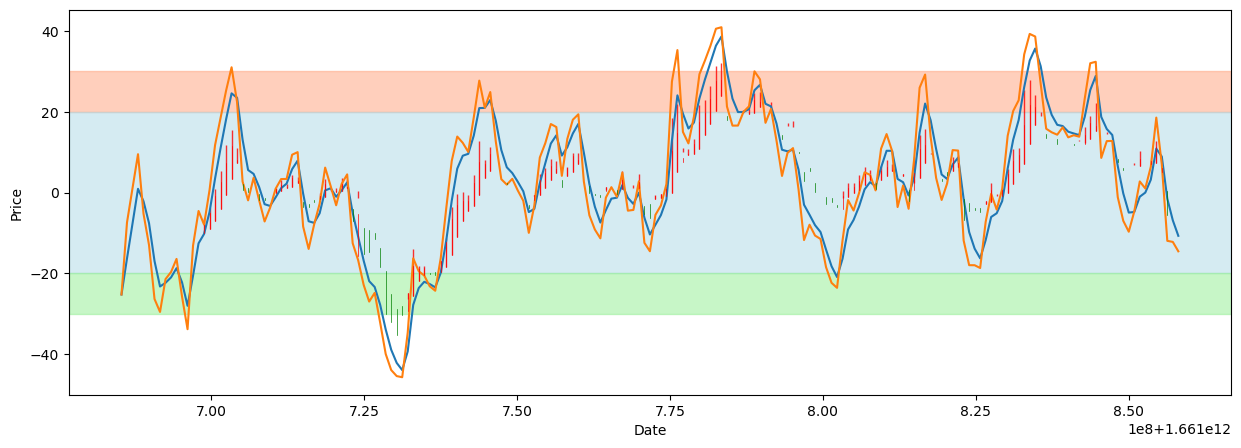

In [12]:
upperx = 30
upper  = 20
median = 0
lower  = -20
lowerx = -30


fig, ax = plt.subplots(figsize=(15,5))

ax.plot(df.index, df.smoothed_rsi)
ax.plot(df.index, df.subtracted_rsi)

ax.axhspan(upper, upperx, alpha=0.5, color='lightsalmon')
ax.axhspan(upper, lower, alpha=0.5, color='lightblue')
ax.axhspan(lower, lowerx, alpha=0.5, color='lightgreen')

# ohlc = ha.index, ha.values 
ohlc = ha.reset_index(level=0)
candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

plt.ylabel("Price")
plt.xlabel("Date")


plt.show()

In [13]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'


# Construct a 2 x 1 Plotly figure
fig = make_subplots(rows=2, cols=1)

# Candlestick chart for pricing
fig.append_trace(
    go.Candlestick(
        x=df.index,
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color='green',
        decreasing_line_color='red',
        showlegend=False

    ), row=1, col=1
)

fig.append_trace(
    go.Candlestick(
        x=df.index,
        open=ha['open'],
        high=ha['high'],
        low=ha['low'],
        close=ha['close'],
        increasing_line_color='green',
        decreasing_line_color='red',
        showlegend=False

    ), row=2, col=1
)

# Selected Rsi
fig.append_trace(
    go.Scatter(
        x=df.index,
        y=df['smoothed_rsi'],
        line=dict(color='#ff9900', width=2),
        name='selected_rsi',
        # showlegend=False,
        # legendgroup='2',

    ), row=2, col=1
)

# 
fig.append_trace(
    go.Scatter(
        x=df.index,
        y=df['subtracted_rsi'],
        line=dict(color='#f0e10e', width=2),
        name='sub_rsi',
        # showlegend=False,
        # legendgroup='2',

    ), row=2, col=1
)

fig.add_hrect(y0=upper, y1=upperx, line_width=0, fillcolor="red", opacity=0.2, row=2, col=1)
fig.add_hrect(y0=upper, y1=lower, line_width=0, fillcolor="blue", opacity=0.2, row=2, col=1)
fig.add_hrect(y0=lower, y1=lowerx, line_width=0, fillcolor="green", opacity=0.2, row=2, col=1)


# Make it pretty
layout = go.Layout(
    plot_bgcolor='#efefef',
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        )
    )
)

# Update options and show plot
fig.update_layout(layout)
fig.show()

In [3]:
def normalized_rsi(source, length):
    return ta.RSI(dataframe[source], window=length)-50

def smooth_rsi(source, length, mode):
    df_rsi = pd.DataFrame()
    df_rsi['rsi'] = normalized_rsi(source, length) # -50 rsi
    df_rsi.dropna(inplace=True)
    df_rsi['smooth'] = df_rsi['rsi']
    
    # _smoothed := na( _smoothed[1] ) ? _zrsi : ( _smoothed[1] + _zrsi ) / 2
    for i in range(df_rsi.shape[0]):
        if i > 0:
            df_rsi.loc[df_rsi.index[i],'smooth'] = (df_rsi['smooth'].iloc[i-1]+ df_rsi['rsi'].iloc[i])/2

    if mode == True:
        return df_rsi['smooth']
    else:
        return df_rsi['rsi']

# RSI Heikin-Ashi generation function
def heikin_ashi_rsi(length):
    df_ha = pd.DataFrame()
    
    df_ha['high'] = rsi('high', length)
    df_ha['low']   = rsi('low', length)
    
    df_ha['high'] =  df_ha.max(axis = 1)
    df_ha['low']  = df_ha.min(axis = 1)
    
    # get close rsi
    df_ha['close'] = rsi('close', length)

    # emulate "open" simply by taking the previous close rsi value
    df_ha['open'] = df_ha['close'].shift()

    # the high and low are tricky, because unlike "high" and "low" by
    # themselves, the RSI results can overlap each other. So first we just go
    # ahead and get the raw results for high and low, and then..

    df_ha.dropna(inplace=True)
    
    for i in range(df_ha.shape[0]):
        if i > 0:
            df_ha.loc[df_ha.index[i],'open'] = ((df_ha['open'].iloc[i-1]* i_smoothing) + df_ha['close'].iloc[i-1])/( i_smoothing + 1 )
        df_ha.loc[df_ha.index[i],'close'] = (df_ha['open'].iloc[i] + df_ha['close'].iloc[i] + df_ha['low'].iloc[i] +  df_ha['high'].iloc[i])/4
       
    df_ha['high'] = df_ha.max(axis = 1)
    df_ha['low'] = df_ha.min(axis = 1)
    return df_ha
    

    
src = 'ohlc4'
length = 7
mode = True

df['smooth_rsi'] = smooth_rsi(src, length, mode)
df['subtract_rsi'] = smooth_rsi(src, length, False)
   
length = 14
i_smoothing = 1
ha = ha = heikin_ashi_rsi(length)

IndentationError: expected an indented block (2609008855.py, line 55)